# Generating Various Types of Graphs by Proximity
This notebook illustrates how to generate and visualize different spatial graph types based on proximity metrics (KNN, Delaunay, Gilbert, Waxman) using City2Graph, OSMnx, and NetworkX.

## Overview
This notebook covers:
- Setting up the environment and importing libraries
- Retrieving points of interest around a location
- Defining helper functions for node extraction and plotting
- Generating and visualizing KNN, Delaunay, Gilbert, and Waxman graphs interactively

## 1. Setup and Environment

In [8]:
import city2graph
import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt
import contextily as ctx

import ipywidgets as widgets
from IPython.display import display

## 2. Retrieve Points of Interest
Fetch restaurant POIs around Shibuya, Tokyo using OSMnx and filter to nodes only.

In [9]:
poi_tags = {
    "amenity": [
        "restaurant"]}

#poi_gdf = ox.features_from_place("Shibuya, Tokyo, Japan", poi_tags)
poi_gdf = ox.features_from_point(
    (35.658514, 139.70133),  # Tokyo Tower coordinates
    tags=poi_tags,
    dist=1000  # Search radius in meters
    )

# Filter to include only nodes, not ways and relations
poi_gdf = poi_gdf[poi_gdf.index.get_level_values('element') == 'node']

# Reproject to a projected CRS for accurate centroids
poi_gdf = poi_gdf.to_crs(epsg=6677)

## 3. Define Helper Functions
Define functions to extract node positions and plot graphs with degree centrality and optional basemap.

In [15]:
def get_node_positions(gdf):
    """Extract node positions from GeoDataFrame."""
    node_positions = {}
    for id, geom in gdf['geometry'].items():
        if geom.geom_type == 'Point':
            node_positions[id] = (geom.x, geom.y)
        else:
            centroid = geom.centroid
            node_positions[id] = (centroid.x, centroid.y)
    return node_positions

def plot_graph(graph, title, node_positions, node_color='skyblue', edge_color='gray', 
               add_basemap=False, crs=None):
    """Plot a network graph with color-coded nodes based on degree centrality."""
    # Compute degree centrality for node coloring
    node_degrees = dict(graph.degree())
    node_colors = [node_degrees.get(node, 0) for node in graph.nodes()]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Set equal aspect ratio to maintain map proportions
    ax.set_aspect('equal')
    
    # Plot the edges with better color
    nx.draw_networkx_edges(graph, pos=node_positions, 
                          edge_color="grey",
                          alpha=0.5,
                          width=0.5, 
                          ax=ax)

    # Plot the POIs with beautiful color scheme
    nodes = nx.draw_networkx_nodes(graph, pos=node_positions, 
                          node_size=30,
                          node_color=node_colors,
                          cmap=plt.cm.plasma,
                          alpha=0.9,
                          linewidths=0.5,
                          ax=ax)
    
    # Add basemap if requested - with no buffer/margin
    if add_basemap and crs:
        ctx.add_basemap(ax, crs=crs, source=ctx.providers.CartoDB.Positron)
        
    # Set exact limits based on node positions to avoid any buffer
    node_xs = [pos[0] for pos in node_positions.values()]
    node_ys = [pos[1] for pos in node_positions.values()]
    ax.set_xlim(min(node_xs), max(node_xs))
    ax.set_ylim(min(node_ys), max(node_ys))
    
    # Add a colorbar with better styling
    cbar = plt.colorbar(nodes, ax=ax, label='Degree Centrality', shrink=0.8)
    cbar.ax.tick_params(labelsize=10)
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

node_positions = get_node_positions(poi_gdf)

## 4. K-Nearest Neighbors (KNN) Graph
Create an interactive slider to plot KNN graphs for varying k values.

In [ ]:
def plot_knn_graph(k_value):
    """Interactive plotting function for KNN graphs."""
    knn_graph = city2graph.knn_graph(poi_gdf, k=k_value)
    plot_graph(knn_graph, 
               f'KNN Graph (k={k_value}) of Restaurants in Shibuya, Tokyo',
               node_positions, 
               edge_color='gray',
               add_basemap=True,
               crs=poi_gdf.crs)

# Create interactive widget with centered and longer slider
k_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=100,
    description='k:',
    continuous_update=False,
    layout=widgets.Layout(width='100%', margin='0 auto'),
    style={'description_width': 'initial'}
)

# Create container to center the slider
slider_container = widgets.HBox([k_slider], layout=widgets.Layout(justify_content='center'))

interactive_plot = widgets.interactive(plot_knn_graph, k_value=k_slider)
interactive_plot.children = (slider_container,) + interactive_plot.children[1:]
display(interactive_plot)


interactive(children=(HBox(children=(IntSlider(value=1, continuous_update=False, description='k:', layout=Layo…

## 5. Delaunay Graph
Generate and plot a Delaunay triangulation graph of the POIs.

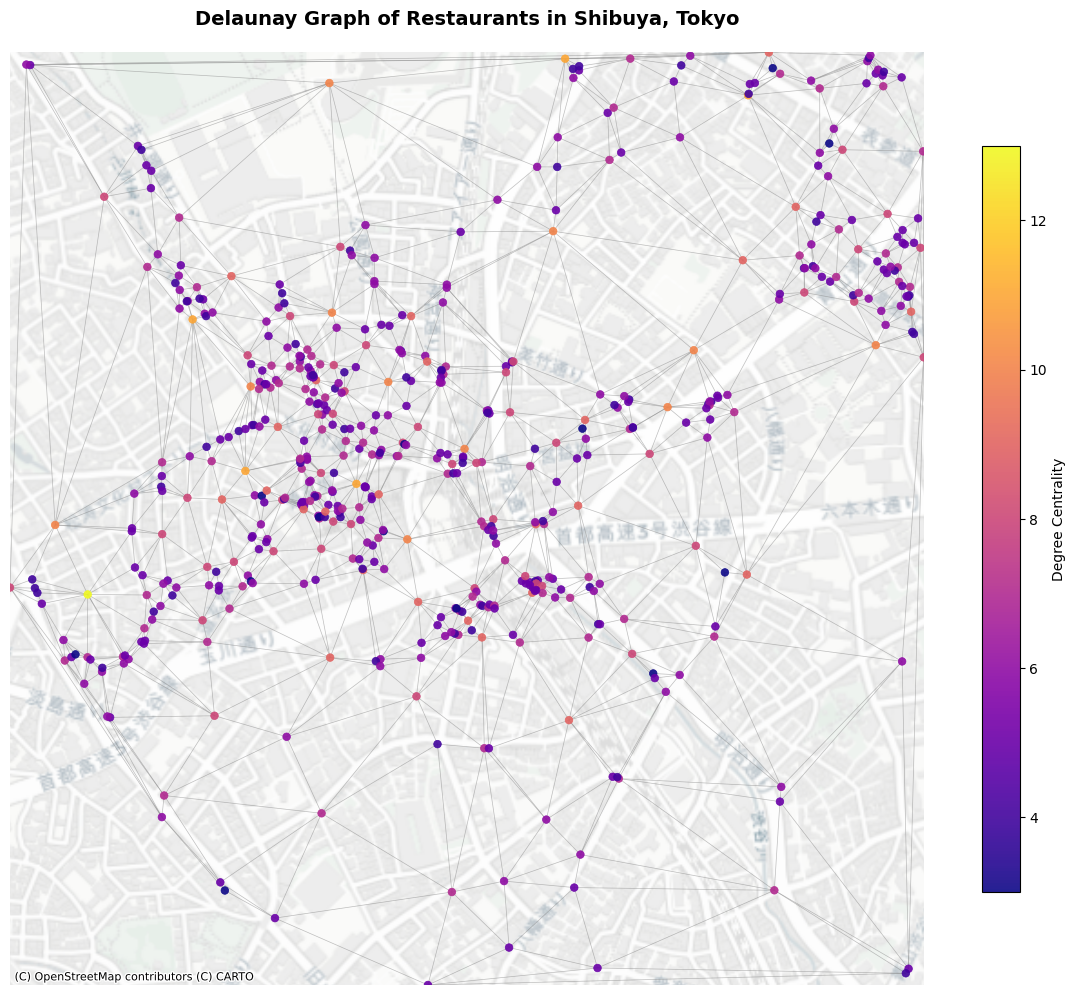

In [17]:
delaunay_graph = city2graph.delaunay_graph(poi_gdf)

# Use the existing plot_graph function with basemap
plot_graph(delaunay_graph, 
           'Delaunay Graph of Restaurants in Shibuya, Tokyo',
           node_positions, 
           node_color='skyblue', 
           edge_color='gray',
           add_basemap=True,
           crs=poi_gdf.crs)


## 6. Gilbert Graph (Hard Threshold Model)
Interactive slider for creating Gilbert graphs with varying radius values.

In [18]:
def plot_gilbert_graph(r_value):
    """Interactive plotting function for Gilbert graphs."""
    gilbert_graph_temp = city2graph.gilbert_graph(poi_gdf, radius=r_value)
    
    plot_graph(gilbert_graph_temp, 
               f'Gilbert Graph (radius={r_value}m) of Restaurants in Shibuya, Tokyo',
               node_positions,
               edge_color='gray',
               add_basemap=True,
               crs=poi_gdf.crs)

# Get node positions once (reuse the existing variable)
if 'node_positions' not in locals():
    node_positions = get_node_positions(poi_gdf)

# Create interactive widget with centered and longer slider
r_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=1000,
    step=1,
    description='radius:',
    continuous_update=False,
    layout=widgets.Layout(width='100%', margin='0 auto'),
    style={'description_width': 'initial'}
)

# Create container to center the slider
slider_container = widgets.HBox([r_slider], layout=widgets.Layout(justify_content='center'))

interactive_plot = widgets.interactive(plot_gilbert_graph, r_value=r_slider)
interactive_plot.children = (slider_container,) + interactive_plot.children[1:]
display(interactive_plot)



interactive(children=(HBox(children=(IntSlider(value=0, continuous_update=False, description='radius:', layout…

## 7. Waxman Graph (Soft Random Geometry Model)
Interactive sliders to generate Waxman graphs with adjustable r0 and beta parameters. The probability of connection follows below: $$H_{ij} = \beta e^{-\frac{d_{ij}}{r_0}}$$

where $d_{ij}$ is the Euclidean distance between node $i$ an $j$; $r_0$ is the maximum distance between nodes; and $\beta$ denotes the scaling parameter.

In [19]:
# Use the plot_graph function from Cell 4 instead of redefining it

def plot_waxman_graph(r0_value, beta_value):
    """Interactive plotting function for Waxman graphs."""
    waxman_graph_temp = city2graph.waxman_graph(gdf=poi_gdf, r0=r0_value, beta=beta_value)
    
    plot_graph(waxman_graph_temp, 
               f'Waxman Graph (r0={r0_value}, beta={beta_value:.2f}) of Restaurants in Shibuya, Tokyo',
               node_positions,
               edge_color='gray',
               add_basemap=True,
               crs=poi_gdf.crs)

# Create interactive widgets for Waxman graph parameters
r0_slider = widgets.IntSlider(
    value=0,
    min=1,
    max=1000,
    step=1,
    description='r0:',
    continuous_update=False,
    layout=widgets.Layout(width='48%'),
    style={'description_width': 'initial'}
)

beta_slider = widgets.FloatSlider(
    value=0,
    min=0,
    max=1.0,
    step=0.01,
    description='beta:',
    continuous_update=False,
    layout=widgets.Layout(width='48%'),
    style={'description_width': 'initial'}
)

# Create container to center both sliders side by side
sliders_container = widgets.HBox([r0_slider, beta_slider], 
                                layout=widgets.Layout(justify_content='center'))

interactive_plot = widgets.interactive(plot_waxman_graph, r0_value=r0_slider, beta_value=beta_slider)
interactive_plot.children = (sliders_container,) + interactive_plot.children[2:]
display(interactive_plot)

interactive(children=(HBox(children=(IntSlider(value=1, continuous_update=False, description='r0:', layout=Lay…